# Imports and funcs

In [13]:
%load_ext autoreload
%autoreload 2
import os
import sys
os.chdir("/data/nils/raving-fader/src")

import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as idp
import librosa
from tqdm import tqdm

import torch.nn.functional as F
import torchaudio.transforms as T
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from audio_descriptors.features import compute_all
from raving_fader.helpers.eval import load_model
torch.set_grad_enabled(False)

In [15]:
def get_features(audio,descriptors,sr,latent_length=64):
    feat = compute_all(audio,sr=sr,descriptors=descriptors,
                                            mean=False,
                                            resample=latent_length)
    
    feat = {descr: feat[descr] for descr in descriptors}
    feat = np.array(list(feat.values())).astype(np.float32)
    return(torch.tensor(feat))

def plot_features(features,descriptors,features_2=None):
    f,axs = plt.subplots(1,5,figsize=(20,5))
    for i,ax in enumerate(axs):
        ax.plot(features[i],label="Original")
        
        if features_2 is not None:
            ax.plot(features_2[i],label="Modified")
        # ax.set_ylim(-1,1)
        ax.set_title(descriptors[i])
        ax.legend()
        
def normalize(features,all_features):
    features_normed = torch.clone(features)
    for i in range(features.shape[1]):
        features_normed[:,i] = 2* ( (features[:,i] - np.min(all_features[:,i])) / (np.max(all_features[:,i]) - np.min(all_features[:,i])) -0.5 ) 
    return features_normed

def compute(model,audio,features_normed,features_shifted):
    with torch.no_grad():
        x = audio.to(model.device).unsqueeze(0)
        x = model.pqmf(x)
        print(x.shape)
        z, kl = model.reparametrize(*model.encoder(x))
        print(z.shape)
        # z=torch.zeros_like(z)
        z_c = torch.cat((z, features_normed.to(model.device)), dim=1)
        y = model.decoder(z_c, add_noise=False)
        y = model.pqmf.inverse(y)
        y = y.squeeze()

        z_c = torch.cat((z, features_shifted.to(model.device)), dim=1)
        y_mod = model.decoder(z_c, add_noise=False)
        y_mod = model.pqmf.inverse(y_mod)
        y_mod = y_mod.squeeze()

        features_rec = get_features(y_mod.detach().cpu().numpy(),model.descriptors,sr=16000).unsqueeze(0)
        features_rec = normalize(features_rec,all_features)
    
    return y,z,y_mod,features_rec

# Loading a model

In [16]:
models_dir = "/data/nils/raving-fader/models/"

#### FRAVE/CRAVE NSynth full

In [17]:
model_name = "FRAVE_nsynthfull" #/CRAVE_nsynthfull
step = 1000000
datapath = "/data/nils/datasets/nsynth_full_valid"

#### FRAVE/CRAVE Combined dataset

In [20]:
model_name = "FRAVE_combined" #/CRAVE_combined
step = 1000000
datapath = "/data/nils/datasets/combined"

#### Import the model

In [19]:
path = os.path.join(models_dir,model_name)
ckpt = os.path.join(path,model_name+"__vae_"+str(step)+".ckpt")
config_file = os.path.join(path,"train_config.yaml")
config,pipeline,model,checkpoint=load_model(config_file,ckpt,datapath=datapath,batch_size=8)
trainloader = pipeline.train_set
all_features = pipeline.dataset.allfeatures
print(checkpoint["step"])

>>> Device : cuda
100524
begin here
2000000


# Load a sample

### From a wav file

In [7]:
wav_path = "/data/nils/datasets/nsynth_full_valid/audio/"

id_wav = random.choice(range(len(os.listdir(wav_path))))
wav_file = os.path.join(wav_path,os.listdir(wav_path)[id_wav])
audio,_ = librosa.load(wav_file,sr=model.sr)
features = get_features(audio,model.descriptors,sr=model.sr).unsqueeze(0)
N = 65536
pad = (N - (len(audio) % N)) % N
audio = np.pad(audio, (0, pad))
audio = torch.tensor(audio).unsqueeze(0).to(model.device)

### From the dataloader

In [21]:
audio,_ = next(iter(trainloader))
audio = audio[:1]
features = get_features(audio.numpy().squeeze(),model.descriptors,sr=model.sr).unsqueeze(0)

# Compute reconstruction

### Descriptors

In [22]:
# Use the orignal descriptors of the sound for reconstruction
features_normed = normalize(features,all_features)
features_shifted=torch.clone(features_normed)

In [23]:
# Change the descriptors. For instance here: shift all the descriptors of a give offsetn
descr =0
offset = 0.2

features_normed = normalize(features,all_features)
features_shifted=torch.clone(features_normed)
features_shifted[:,descr] = features_shifted[:,descr]+offset

### Reconstruction and results

In [24]:
y,z,y_mod,features_rec = compute(model,audio,features_normed,features_shifted)

torch.Size([1, 8, 8192])
torch.Size([1, 128, 64])


Original Audio


Reconstruction with same attributes


Reconstruction with modified attributes


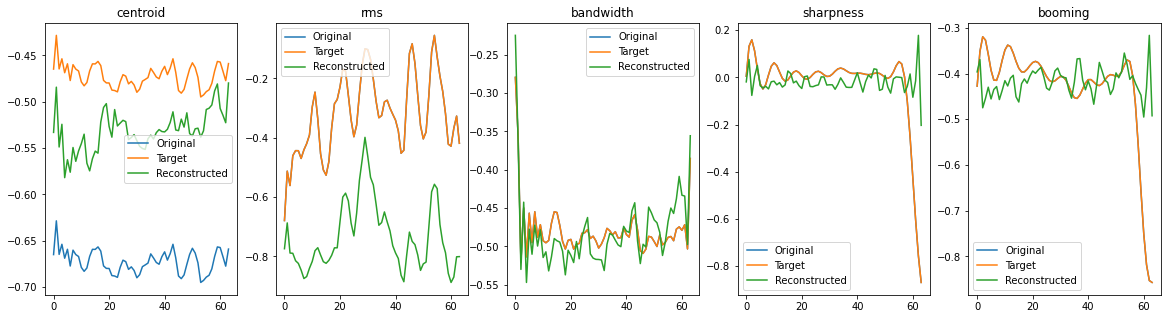

In [25]:
f,axs = plt.subplots(1,5,figsize=(20,5))
for i,ax in enumerate(axs):
    ax.plot(features_normed.squeeze()[i],label="Original")
    ax.plot(features_shifted.squeeze()[i],label="Target")
    ax.plot(features_rec.squeeze()[i],label="Reconstructed")
    # ax.set_ylim(-1,1)
    ax.set_title(model.descriptors[i])
    ax.legend()

print("Original Audio")
idp.display(idp.Audio(audio.cpu().numpy(),rate = model.sr))

print("Reconstruction with same attributes")
idp.display(idp.Audio(y.cpu().numpy(),rate = model.sr))

print("Reconstruction with modified attributes")
idp.display(idp.Audio(y_mod.cpu().numpy(),rate = model.sr))